# 1. Introduction

## 🧪 EDA: Women in STEM Dataset

This notebook performs exploratory data analysis (EDA) on the dataset regarding women's participation in STEM education globally.

- Goal: Understand the data and prepare for model development and deployment.
- Target: `female_graduation_rate`
- Features: Temporal, geographic, and STEM field metrics.

## 2. Imports and config

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re
import os
import requests
import zipfile
import joblib
import shutil
import opendatasets as od

# Set plotting size and style
sns.set_theme(rc = {'figure.figsize':(16, 8)})
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# Download to a temp folder
od.download(
    "https://www.kaggle.com/datasets/bismasajjad/womens-representation-in-global-stem-education",
    data_dir="../data/raw/tmp_kaggle"
)

# Move CSV to raw folder
shutil.move(
    "../data/raw/tmp_kaggle/womens-representation-in-global-stem-education/women_in_stem.csv",
    "../data/raw/women_in_stem.csv"
)

# Remove the extra folders
shutil.rmtree("../data/raw/tmp_kaggle")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/bismasajjad/womens-representation-in-global-stem-education


100%|██████████| 4.86k/4.86k [00:00<00:00, 13.2MB/s]

## 3. Load and clean data

In [67]:
# Load the dataset
df = pd.read_csv('../data/raw/women_in_stem.csv')
df.head()

,Country,Year,Female Enrollment (%),Female Graduation Rate (%),STEM Fields,Gender Gap Index
0,China,2018,20.4,43.2,Engineering,0.52
1,China,2005,35.6,29.3,Mathematics,0.98
2,China,2005,53.7,32.4,Biology,0.60
3,Germany,2007,65.0,63.6,Mathematics,0.69
4,Canada,2010,54.4,28.8,Engineering,0.74


In [68]:
# Transform column names: make lowercase, remove parentheses and content inside
df.columns = df.columns.str.lower().str.replace(r"\s*\([^)]*\)", "", regex=True).str.replace(" ", "_").str.strip("_")  
df.columns

Index(['country', 'year', 'female_enrollment', 'female_graduation_rate',
       'stem_fields', 'gender_gap_index'],
      dtype='object')

## 4. Initial structure

In [69]:
# Display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 500 non-null    object 
 1   year                    500 non-null    int64  
 2   female_enrollment       500 non-null    float64
 3   female_graduation_rate  500 non-null    float64
 4   stem_fields             500 non-null    object 
 5   gender_gap_index        500 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 23.6+ KB


In [70]:
# Display descriptive statistics
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,500,6,China,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,500.0,NaN,NaN,NaN,2011.418,7.187112,2000.0,2005.0,2011.0,2018.0,2023.0
female_enrollment,500.0,NaN,NaN,NaN,43.9398,14.316864,20.1,31.575,43.5,56.5,69.5
female_graduation_rate,500.0,NaN,NaN,NaN,36.7152,15.964231,10.1,23.15,35.9,50.425,64.9
stem_fields,500,4,Mathematics,137,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender_gap_index,500.0,NaN,NaN,NaN,0.74598,0.138183,0.5,0.63,0.75,0.86,1.0


## 5. Data quality

In [71]:
# Define a function to check data quality
def check_data_quality(df, name="DataFrame"):
    print(f"--- Data Quality Report for: {name} ---\n")
    print("Rows           :", df.shape[0])
    print("Columns        :", df.shape[1])
    print("\nFeatures       :", df.columns.tolist())
    print("\nMissing Values :", df.isnull().sum().values.sum())
    print("Duplicates     :", df.duplicated().sum())
    print("\nUnique Values  :\n", df.nunique())
    print("\nMemory Usage   : %.2f MB" % (df.memory_usage().sum() / 1024**2))
    print("\n--- End of Report ---")

In [72]:
# Check data quality
check_data_quality(df)

--- Data Quality Report for: DataFrame ---

Rows           : 500
Columns        : 6

Features       : ['country', 'year', 'female_enrollment', 'female_graduation_rate', 'stem_fields', 'gender_gap_index']

Missing Values : 0
Duplicates     : 0

Unique Values  :
 country                     6
year                       24
female_enrollment         326
female_graduation_rate    336
stem_fields                 4
gender_gap_index           51
dtype: int64

Memory Usage   : 0.02 MB

--- End of Report ---


In [73]:
# Set output directory for reports
output_dir = "/home/konstan_souf/mlops/women-in-stem-mlops-project/monitoring/reports/eda"

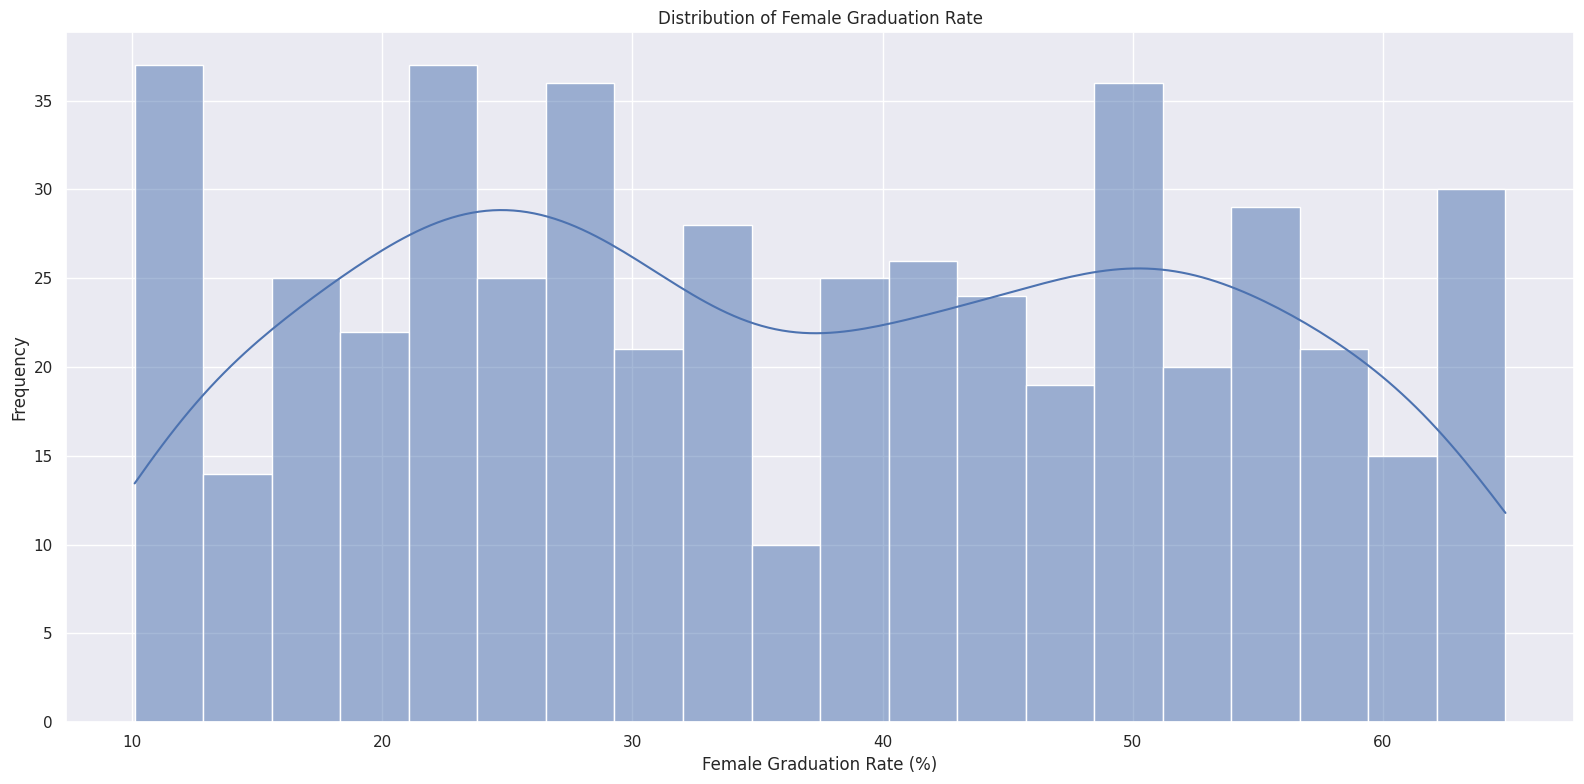

In [74]:
# Histogram of the target variable
sns.histplot(df["female_graduation_rate"], kde=True, bins=20)
plt.title("Distribution of Female Graduation Rate")
plt.xlabel("Female Graduation Rate (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'distribution_target_variable.png'), dpi=300)
plt.show()

### Insights from Histogram
Bimodal Tendency: Peaks around ~15% and ~50% suggest two separate groups of countries or fields.

Wide Spread: Graduation rates span broadly from ~10% to ~65%, which provides enough variance for regression modeling.

Moderate Skew: Slight tail toward lower values — but not extreme → no immediate need for transformation.

## 6. Categorical distribution

In [75]:
# Display value counts for specific columns
print(df['country'].value_counts())
print(df['stem_fields'].value_counts())

country
China        88
Australia    87
Canada       86
India        82
USA          82
Germany      75
Name: count, dtype: int64
stem_fields
Mathematics         137
Engineering         132
Biology             119
Computer Science    112
Name: count, dtype: int64


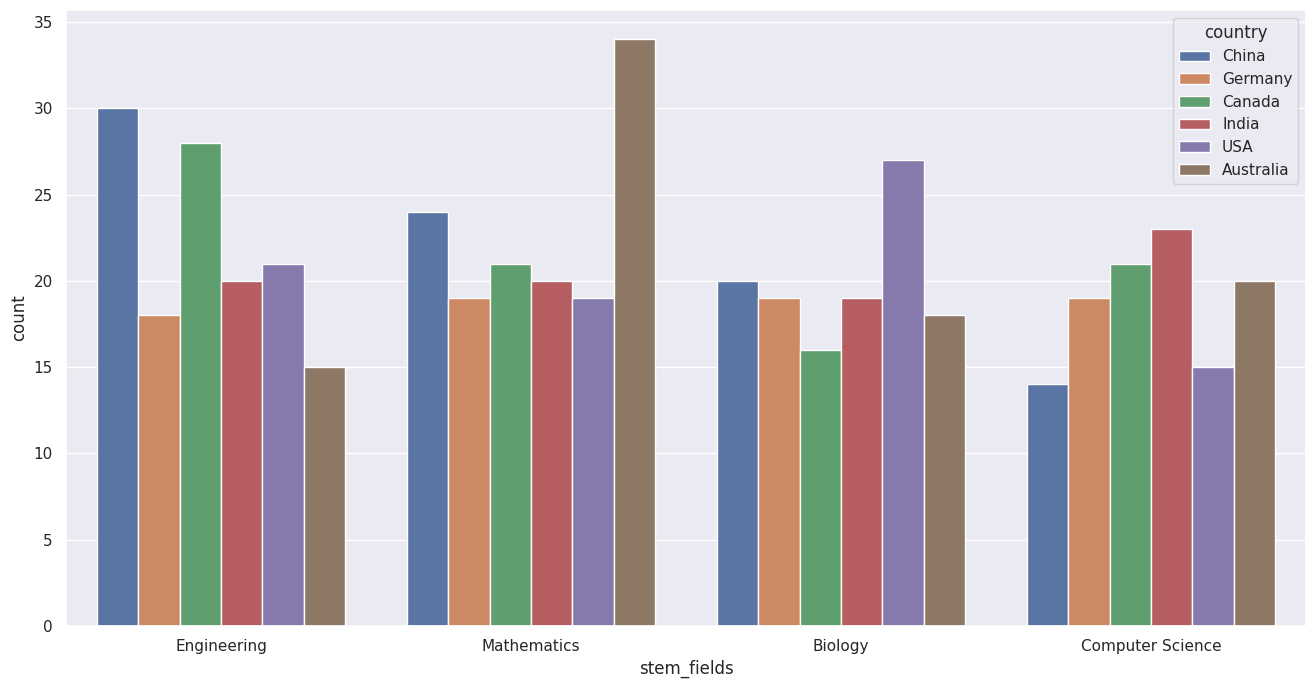

In [76]:
sns.countplot(data=df, x="stem_fields", hue="country")
plt.savefig(os.path.join(output_dir, "stem_field_distribution.png"), dpi=300)
plt.show()

## 7. Time trends

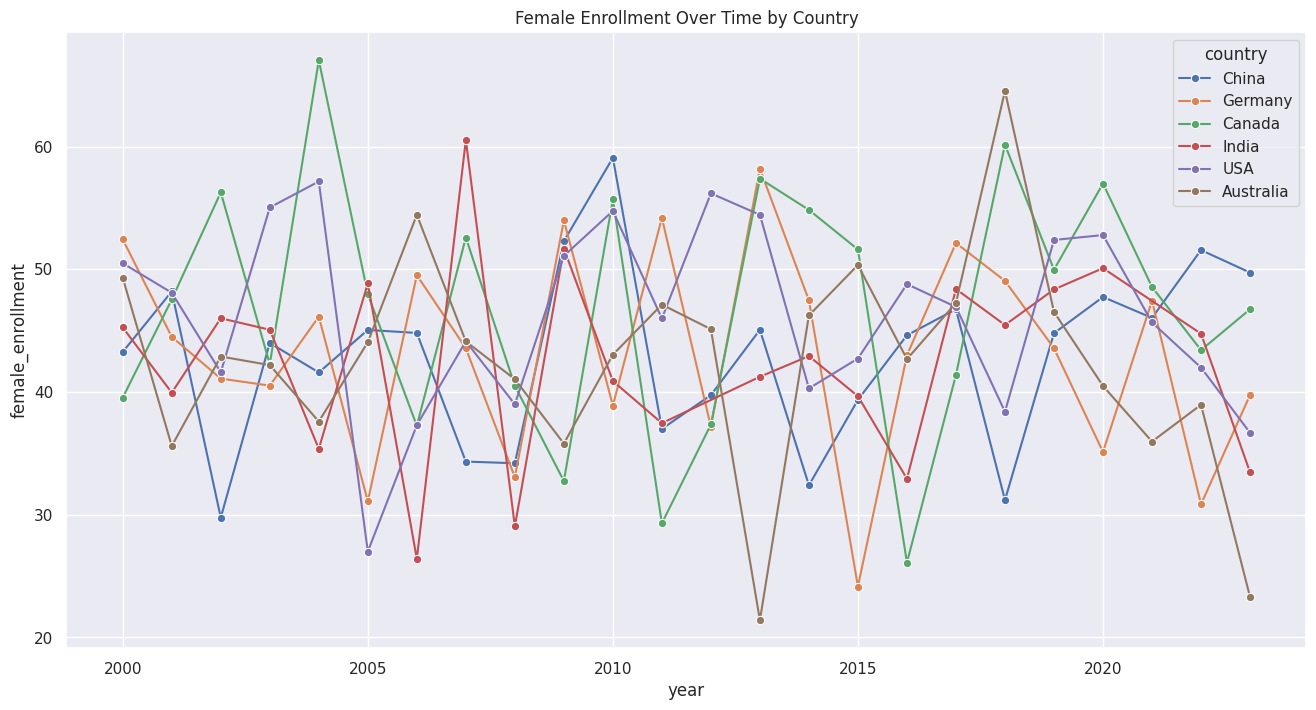

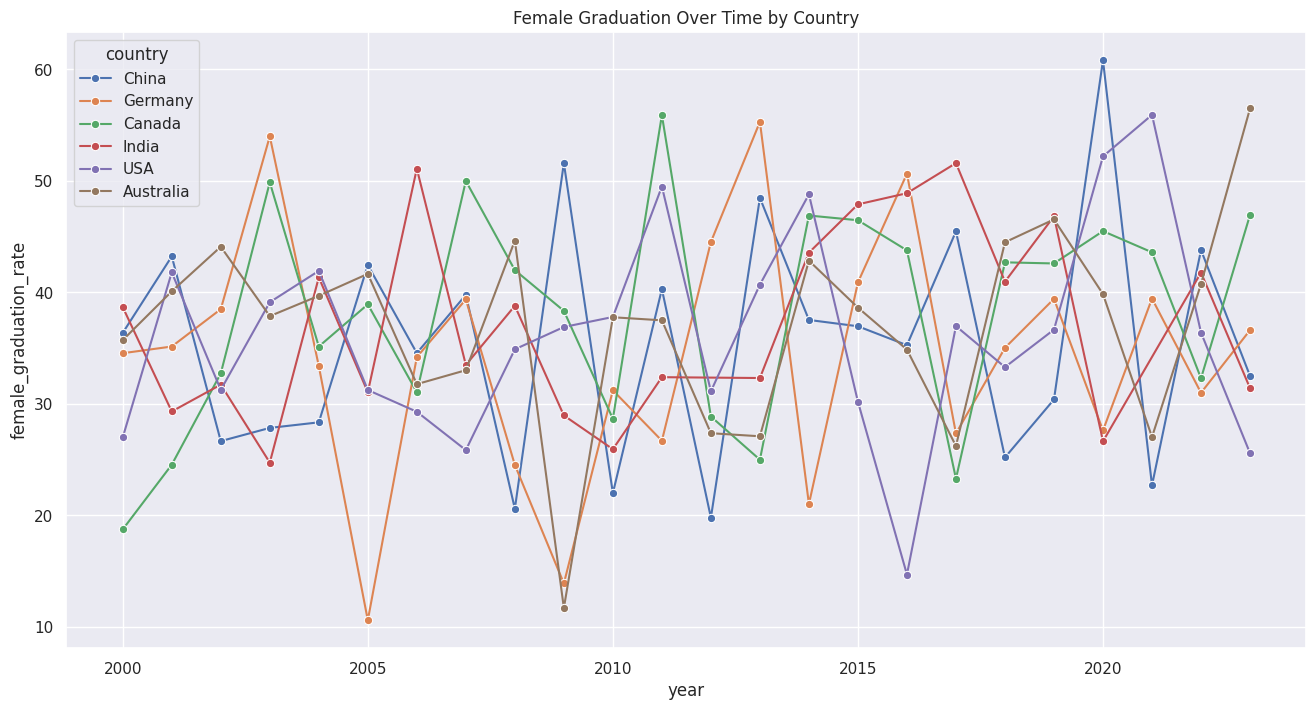

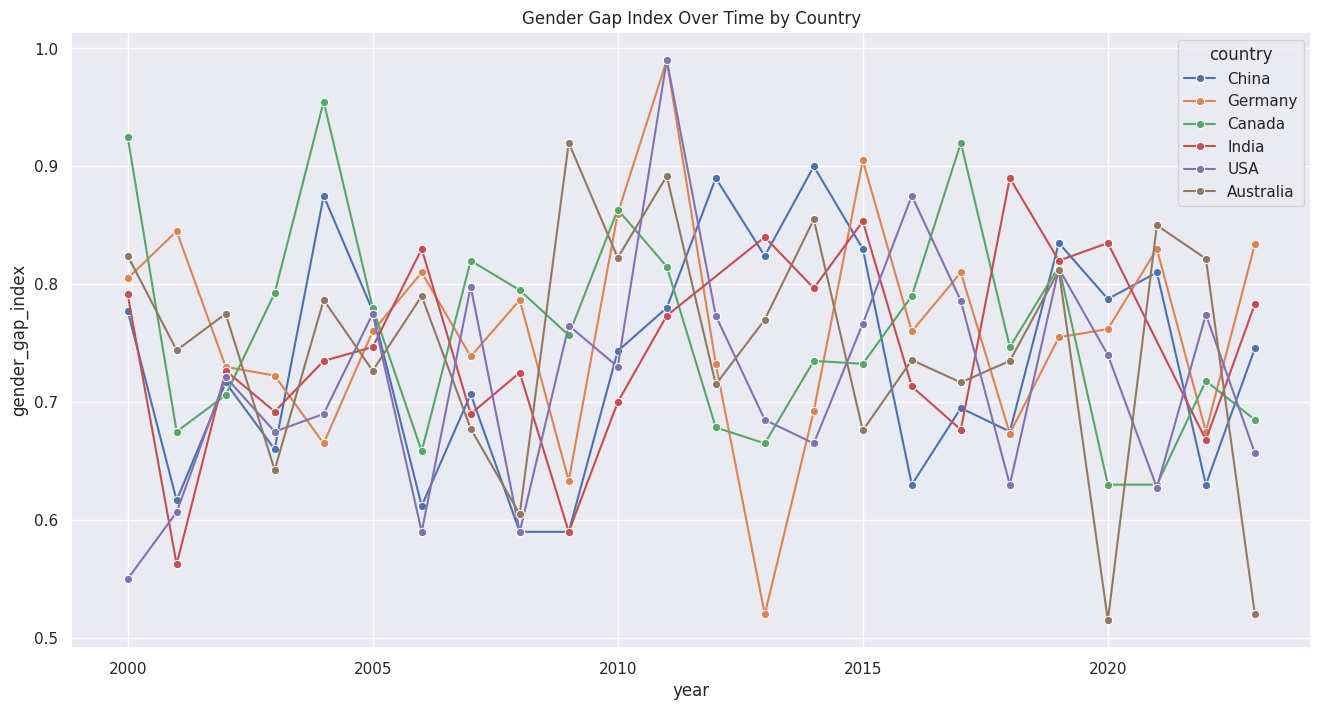

In [77]:
# Country-based analysis
sns.lineplot(data=df, x='year', y='female_enrollment', hue='country', marker='o',errorbar=None)
plt.title('Female Enrollment Over Time by Country')
plt.savefig(os.path.join(output_dir, "Female_Enrollment_Over_Time_by_Country.png"), dpi=300)
plt.show()

sns.lineplot(data=df, x='year', y='female_graduation_rate', hue='country', marker='o',errorbar=None)
plt.title('Female Graduation Over Time by Country')
plt.savefig(os.path.join(output_dir, "Female_Graduation_Over_Time_by_Country.png"), dpi=300)
plt.show()

sns.lineplot(data=df, x='year', y='gender_gap_index', hue='country', marker='o',errorbar=None)
plt.title('Gender Gap Index Over Time by Country')
plt.savefig(os.path.join(output_dir, 'Gender_Gap_Index_Over_Time_by_Country.png'), dpi=300)
plt.show()

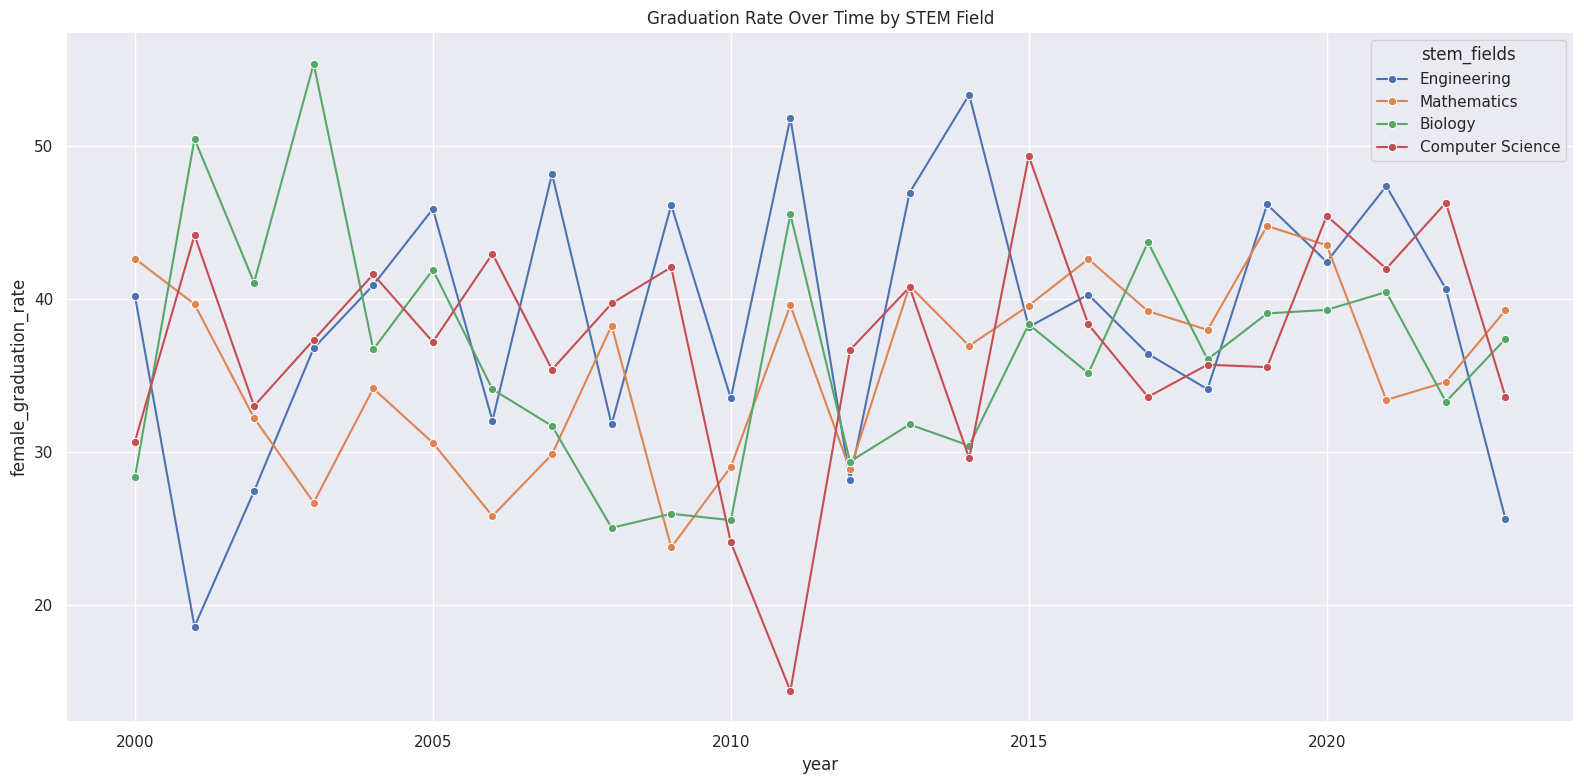

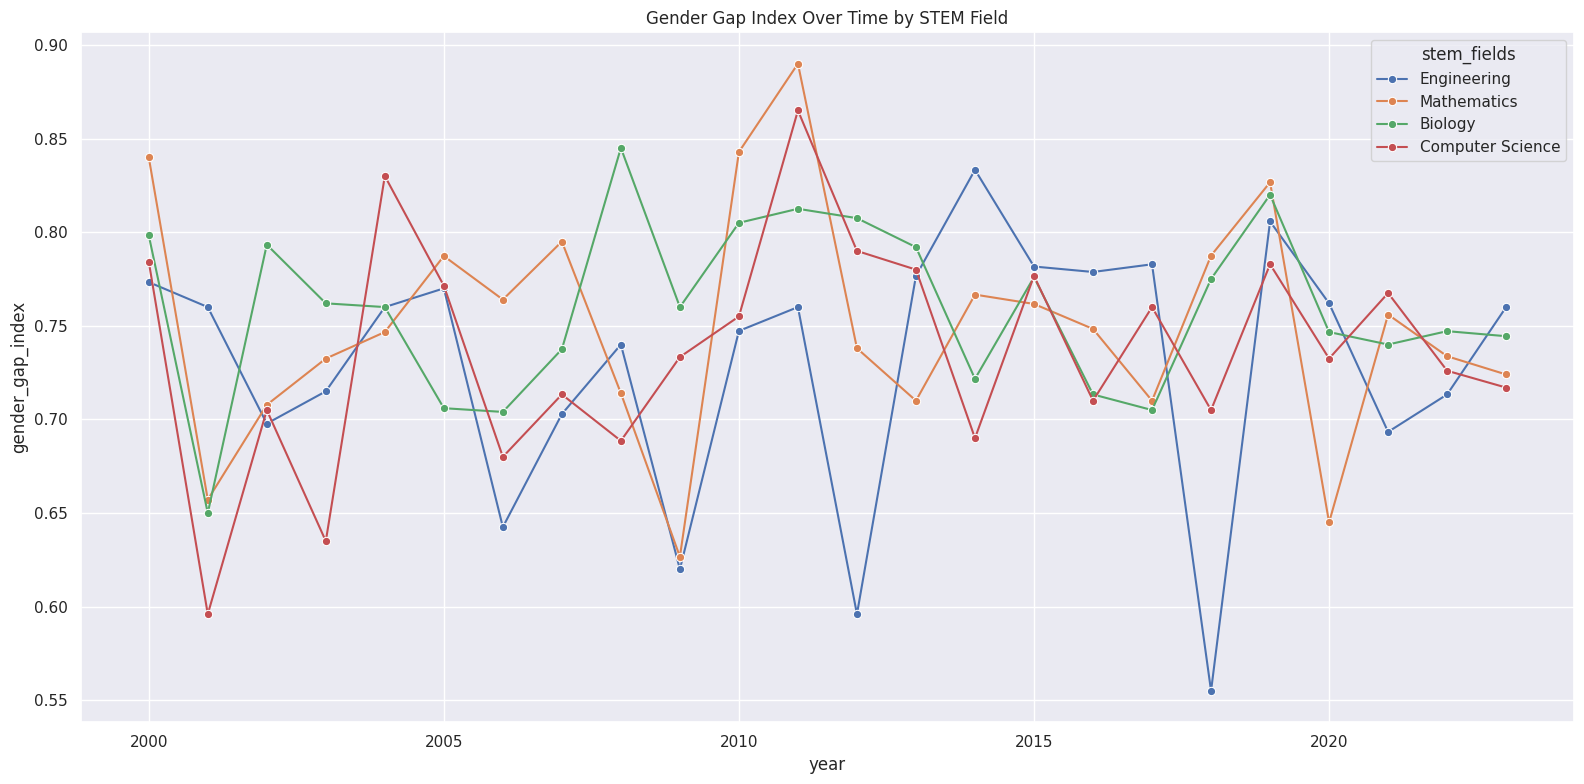

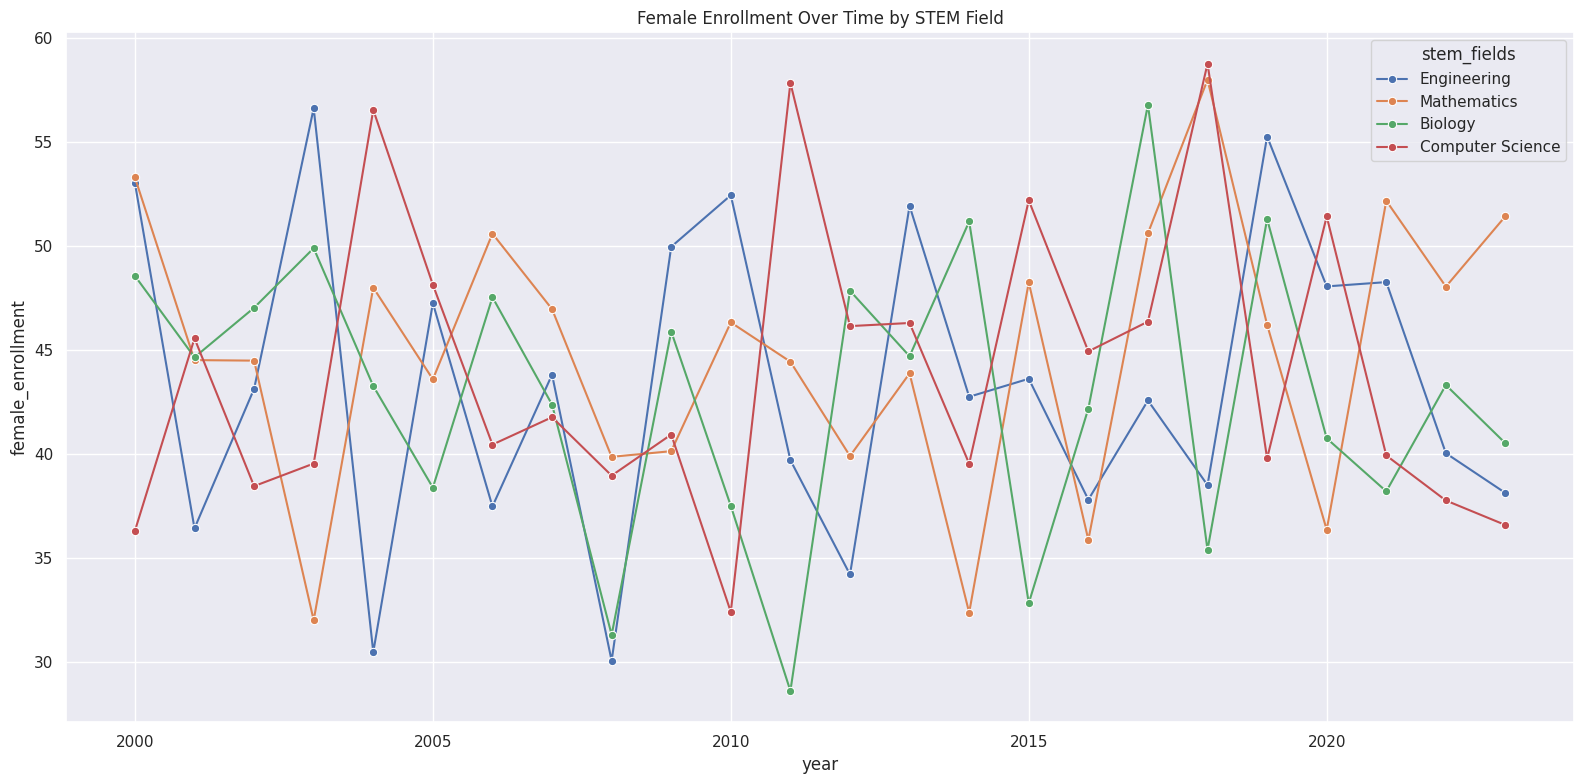

In [78]:
# STEM field-based analysis
sns.lineplot(data=df, x='year', y='female_graduation_rate', hue='stem_fields', marker='o', errorbar=None)
plt.title('Graduation Rate Over Time by STEM Field')
plt.savefig(os.path.join(output_dir, 'Graduation_Rate_Over_Time_by_STEM_Field.png'), dpi=300)
plt.tight_layout()
plt.show()

sns.lineplot(data=df, x='year', y='gender_gap_index', hue='stem_fields', marker='o',errorbar=None)
plt.title('Gender Gap Index Over Time by STEM Field')
plt.savefig(os.path.join(output_dir, 'Gender_Gap_Index_Over_Time_by_STEM_Field.png'), dpi=300)
plt.tight_layout()
plt.show()

sns.lineplot(data=df, x='year', y='female_enrollment', hue='stem_fields', marker='o',errorbar=None)
plt.title('Female Enrollment Over Time by STEM Field')
plt.savefig(os.path.join(output_dir, 'Female_Enrollment_Over_Time_by_STEM_Field.png'), dpi=300)
plt.tight_layout()
plt.show()

In [79]:
# Compare gender gaps across STEM fields
field_analysis = df.groupby('stem_fields').agg({
   'female_enrollment': 'mean',
   'female_graduation_rate': 'mean',
   'gender_gap_index': 'mean'
}).round(2)
print("Average Metrics by STEM Field:")
print(field_analysis)

Average Metrics by STEM Field:
                  female_enrollment  female_graduation_rate  gender_gap_index
stem_fields                                                                  
Biology                       42.93                   35.84              0.76
Computer Science              43.08                   37.46              0.73
Engineering                   44.01                   38.18              0.74
Mathematics                   45.45                   35.45              0.76


##  8. Field-wise plots

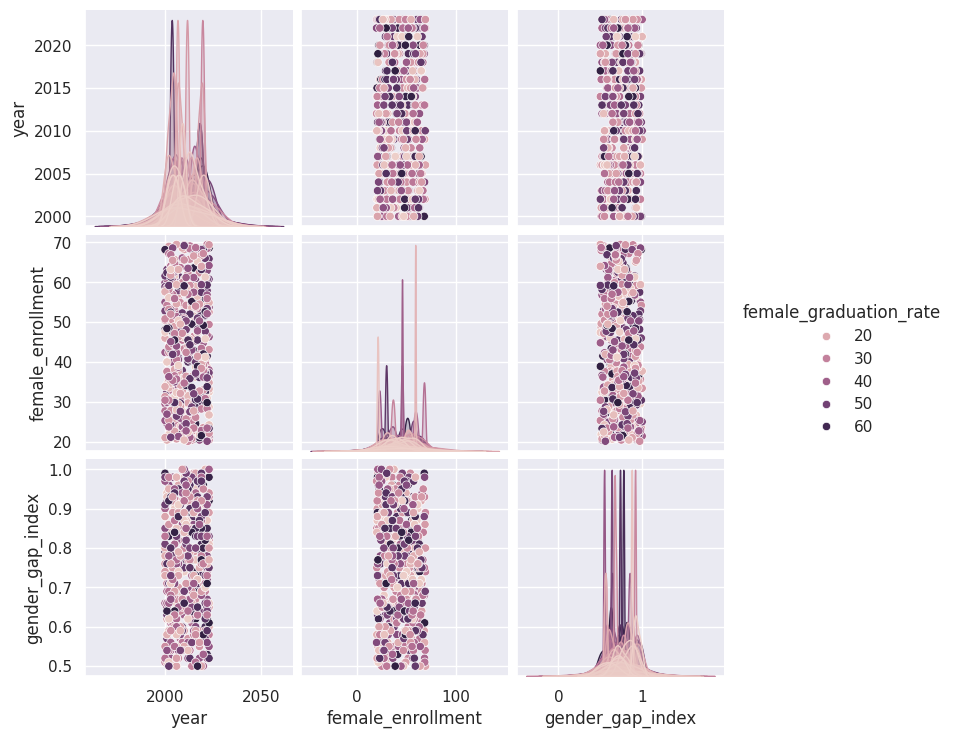

In [80]:
# Visualize pairwise relationships in the dataset
sns.pairplot(df, hue='female_graduation_rate')
plt.savefig(os.path.join(output_dir, 'pairwise_relationships.png'), dpi=300)
plt.show()

##  9. Correlation

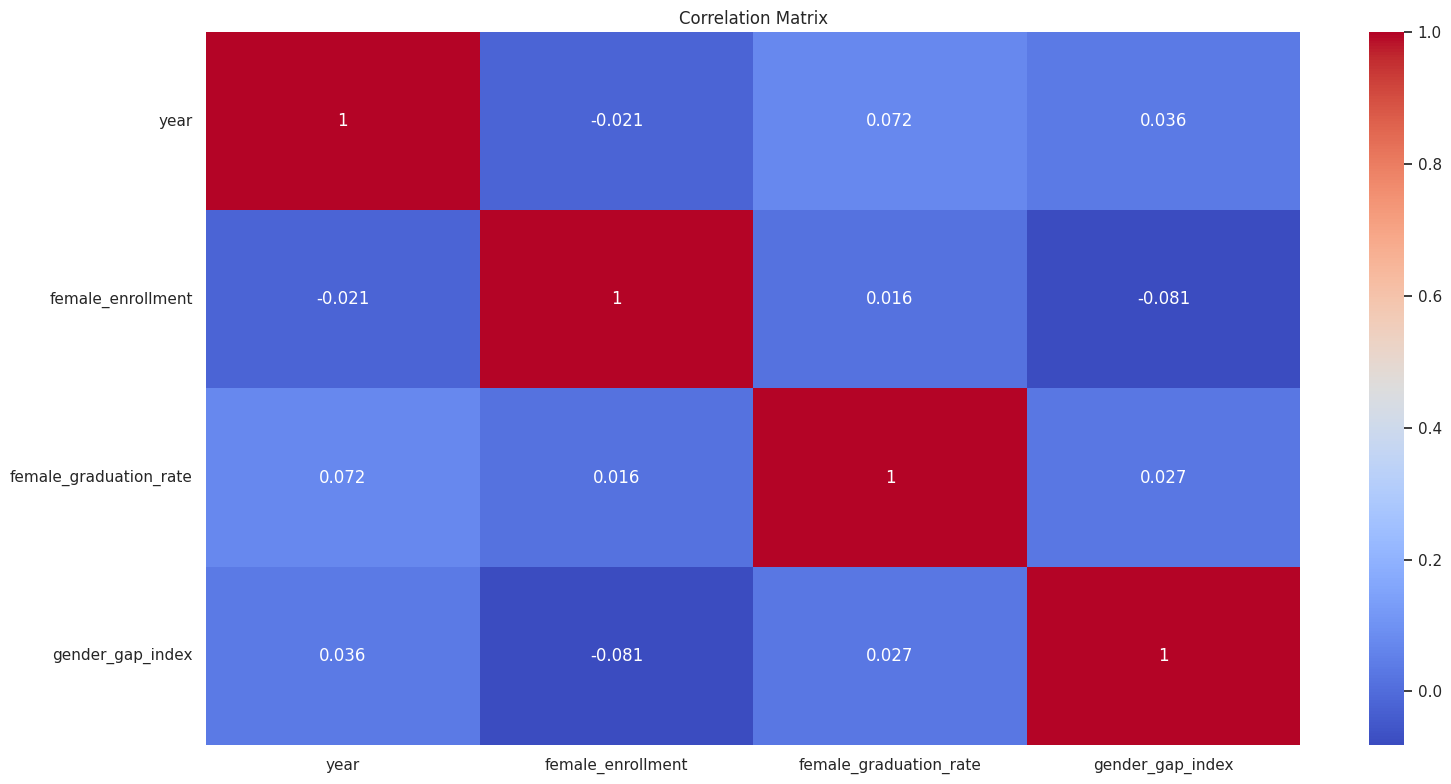

In [81]:
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.savefig(os.path.join(output_dir, 'correlation_matrix.png'), dpi=300)
plt.tight_layout()
plt.show()

## 10. Outliers    

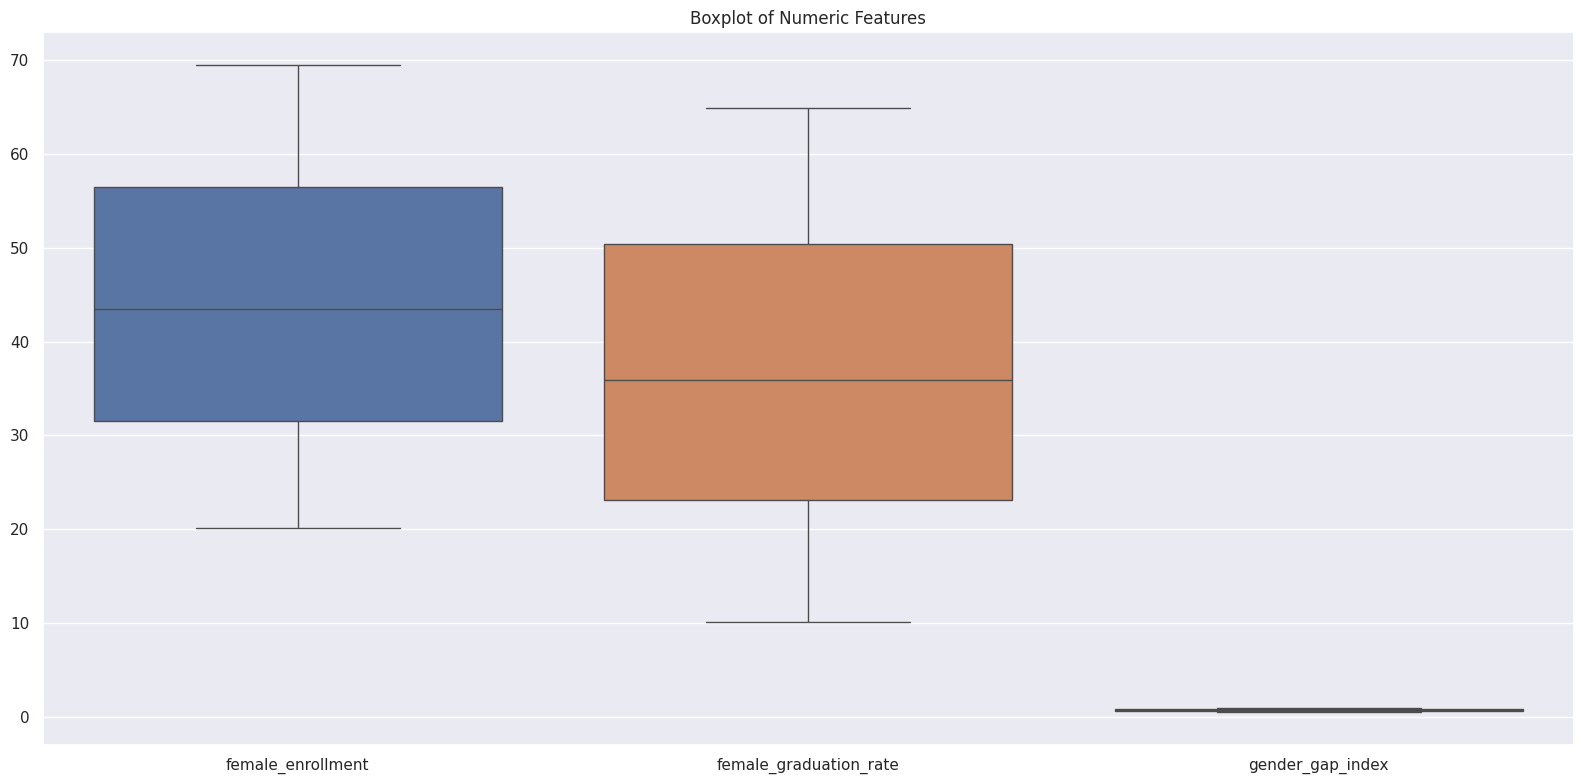

In [82]:
sns.boxplot(data=df[['female_enrollment', 'female_graduation_rate', 'gender_gap_index']])
plt.title("Boxplot of Numeric Features")
plt.savefig(os.path.join(output_dir, 'boxplot_numeric_features.png'), dpi=300)
plt.tight_layout()
plt.show()

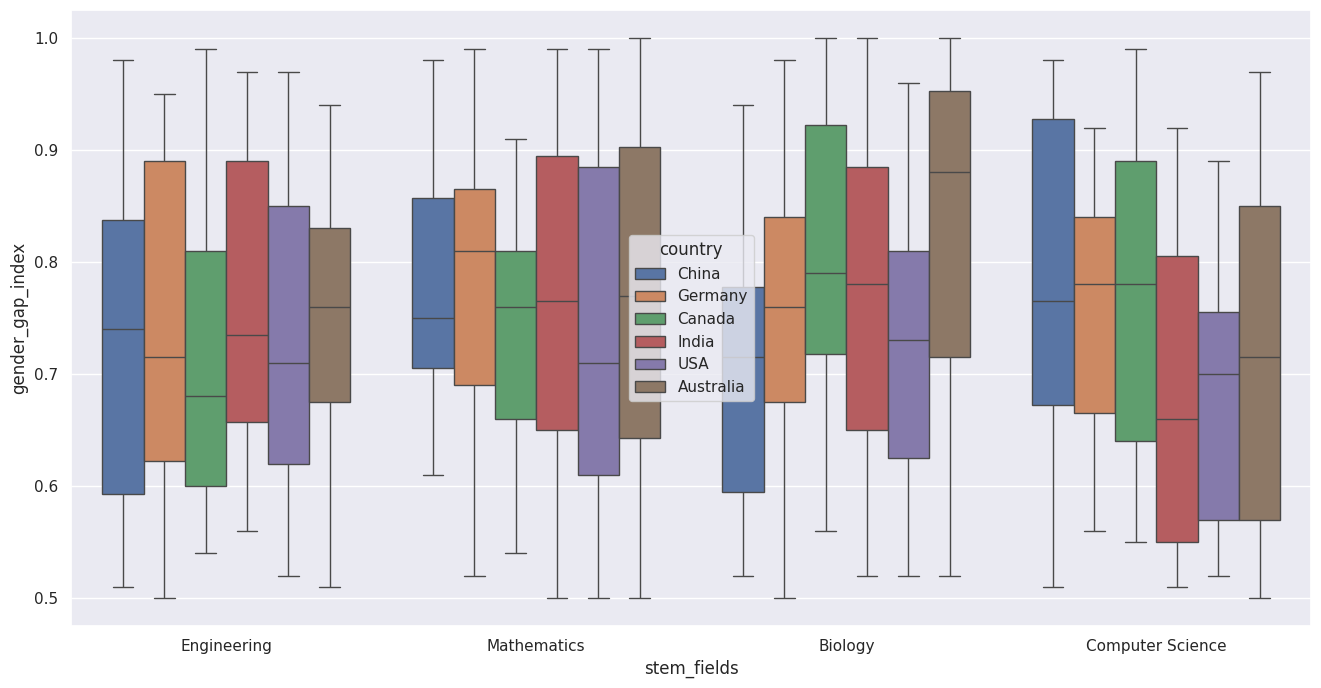

In [83]:
sns.boxplot(data=df, x='stem_fields', y='gender_gap_index', hue='country')
plt.savefig(os.path.join(output_dir, 'boxplots_by_stem_fields.png'), dpi=300)
plt.show()

## 11. Summary

### Data Composition
500 entries across 6 countries and 4 STEM fields from 2000–2023.

No missing values, no duplicates → clean dataset.

Numerical Features:

female_enrollment: Mean ≈ 44%, Range [20.1%, 69.5%]

female_graduation_rate: Mean ≈ 37%, Range [10.1%, 64.9%]

gender_gap_index: Mean ≈ 0.75, Range [0.50, 1.00]

###  STEM Field Distribution
Most common: Mathematics (137 entries), least: CS (112).

Distribution is slightly imbalanced but usable.

### Temporal Trends
Female Enrollment shows high volatility across countries.

Graduation Rate has fluctuated but trends upward in some regions.

Gender Gap Index appears stable in most countries, with variance in Australia and Canada.

### Field-wise Insights
Highest average graduation: Engineering (38.18%)

Highest average enrollment: Mathematics (45.45%)

Lowest gap index: Computer Science (0.73), hinting at slightly more disparity.

### Correlations
Surprisingly low correlation among numeric features:

Graduation ↔ Enrollment: 0.016

Graduation ↔ Gender Gap: 0.027

In [84]:
# Save the cleaned DataFrame
df.to_csv('../data/processed/women_in_stem_cleaned.csv', index=False)